In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.externals.joblib import Memory
from sklearn.metrics import classification_report
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

In [260]:
##commented out data are not normalized,importing in normalized data
# data_train= pd.read_csv(
#     "/Users/geickelb1/Box/PAII_project/processed_data/imputed_datasets/training/20190226_median_imputed_train.csv")

data_train=pd.read_csv(
    "/Users/geickelb1/Box/PAII_project/processed_data/imputed_datasets/testing/20190304_median_imputed_processed_train.csv")


# data_test= pd.read_csv(
#     "/Users/geickelb1/Box/PAII_project/processed_data/imputed_datasets/testing/20190226_median_imputed_test.csv")

data_test=pd.read_csv(
    "/Users/geickelb1/Box/PAII_project/processed_data/imputed_datasets/testing/20190304_median_imputed_processed_test.csv")


time: 191 ms


In [261]:
#seperate y from x's.
y_train= data_train.pop('iGram_pos').values
x_train= data_train#.drop(['iGram_pos'], axis=1)
y_test= data_test.pop('iGram_pos').values
x_test= data_test#.drop(['iGram_pos'], axis=1)

#for strings we can use pd.get_dummies() rather than onehotencoder below:
cols_to_transform=['rrt',
                   'phenylephrine',
                   'norepinephrine',
                   'vasopressin',
                   'dobutamine',
                   'dopamine',
                   'epinephrine',
                   'leukocyte',
                   'vent_recieved',
                   'ethnicity',
                   'nitrite',
                   'gender',
                   'ibands',
                   'ipco2']
x_train = pd.get_dummies(x_train, columns = cols_to_transform )
x_test = pd.get_dummies(x_test, columns = cols_to_transform )

time: 126 ms


In [262]:
list(x_train)

['bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'daily_sofa',
 'first_admit_age',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'potassium',
 'ptt',
 'resprate',
 'temperature',
 'weight',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2Ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'maxCalcium',
 'maxSodium',
 'maxWBC',
 'minCalcium',
 'minSodium',
 'minWBC',
 'rrt_False',
 'rrt_True',
 'phenylephrine_False',
 'phenylephrine_True',
 'norepinephrine_False',
 'norepinephrine_True',
 'vasopressin_False',
 'vasopressin_True',
 'dobutamine_False',
 'dobutamine_True',
 'dopamine_False',
 'dopamine_True',
 'epinephrine_False',
 'epinephrine_True',
 'leukocyte_Neg/Not_tested',
 'leukocyte_pos',
 'vent_recieved_Mech',
 'vent_recieved_None',
 'vent_recieved_Oxygen',
 'ethnicity_asian',
 'ethnicity_black',
 'ethnicity_hispanic',
 'ethnicity_unknown/other',
 'ethnicity_white/nonhispanic',
 'nitrite_Neg/Not_tested',
 'nitrite_pos',
 'gender_F',
 'gender_M',
 'i

time: 4.57 ms


In [263]:
from sklearn.ensemble import RandomForestClassifier

time: 3.13 ms


In [30]:
w = 50 # The weight for the positive class

RF = RandomForestClassifier(class_weight={0: 1, 1: w})

time: 1.48 ms


In [47]:
5617/pd.DataFrame(y_train)[0].value_counts()

culture_neg     1.000000
gram_pos       19.989324
gram_neg       39.836879
Name: 0, dtype: float64

time: 4.91 ms


In [49]:
class_weight={'culture_neg':1,'gram_pos':20,'gram_neg':40}
class_weight

{'culture_neg': 1, 'gram_neg': 40, 'gram_pos': 20}

time: 2.45 ms


In [68]:
# classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
# classifier.fit(X_train, y_train)

RF = RandomForestClassifier(class_weight={'culture_neg':1,'gram_pos':20,'gram_neg':40},
                            n_estimators=100,
                            max_depth=2,
                            random_state=0)

RF.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True,
            class_weight={'culture_neg': 1, 'gram_pos': 20, 'gram_neg': 40},
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

time: 280 ms


This tells us the most important settings are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features).

* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

In [73]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

time: 11.5 ms


### Random Search Training
Now, we instantiate the random search and fit it like any Scikit-Learn model:

In [76]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
RF = RandomForestClassifier(class_weight={'culture_neg':1,'gram_pos':20,'gram_neg':40})
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = RF,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1
                               )


# # run randomized search
# n_iter_search = 20
# random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
#                                    n_iter=n_iter_search, cv=5)


# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=400, mi

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   58.2s


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=70, bootstrap=True, total=   4.5s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=70, bootstrap=True, total=   5.0s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False, total=  18.5s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False, total=  18.9s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1000,

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.3min


[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=  21.6s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=  21.8s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=  22.2s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, total=  11.0s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimato

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.9min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True,
            class_weight={'culture_neg': 1, 'gram_pos': 20, 'gram_neg': 40},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='w

time: 10min 57s


In [77]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400}

time: 2.29 ms


{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400}

In [137]:
class_weight= 'balanced_subsample'
RF = RandomForestClassifier(class_weight=class_weight,
                            n_estimators=400,
                            max_depth=30,
                            max_features= 'sqrt',
                            min_samples_leaf= 1,
                            min_samples_split= 5,
                            bootstrap= True)

RF.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=30, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

time: 5.34 s


In [141]:
class_weight= 'balanced_subsample'
RF2 = RandomForestClassifier(class_weight=class_weight,
                            n_estimators=400,
                            max_depth=30,
                            max_features= 'sqrt',
                            min_samples_leaf= 3,
                            min_samples_split= 5,
                            bootstrap= True,
                           criterion="entropy")

RF2.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=30, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

time: 5.12 s


In [179]:
def fxn1(i):
    if i == 'culture_neg':
        return(0.01)
    elif i=='gram_neg':
        return(200.0)
    else:
        return(200.0)

sample_weight_train = [fxn1(i) for i in y_train]
#y_test.apply(fxn1)


time: 5.79 ms


In [180]:
#evaluate random search

#class_weight= {'culture_neg':1,'gram_pos':20,'gram_neg':40}
class_weight= 'balanced_subsample'
base_model = RandomForestClassifier(n_estimators = 10,
                                    class_weight=class_weight)
base_model.fit(x_train, y_train, sample_weight=sample_weight_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

time: 159 ms


In [184]:
base_model.feature_importances_
y_train_hat = RF.predict(x_train)
print(confusion_matrix(y_train_hat, y_train))

[[5617    0    0]
 [   0  141    0]
 [   0    0  281]]
time: 358 ms


In [172]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy= sum(predictions==test_labels)/len(test_labels)
    #errors = abs(predictions - test_labels)
    #mape = 100 * np.mean(errors / test_labels)
    #accuracy = 100 - mape
    print('Model Performance')
    #print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_accuracy = evaluate(base_model, x_train, y_train)
tuned_accuracy = evaluate(RF, x_train, y_train)

Model Performance
Accuracy = 0.99%.
Model Performance
Accuracy = 1.00%.
time: 372 ms


## modeling isn't going well (nnet overfit to training, rf predicting all culture neg despite parameters), lets look at what Yuan and Nelson have to say:

# labmeting notes:

## first step: visualize with t sne or pca
* maybe need to better construct features. (ie for maybe non gaussian shape of classes)
* if 3 classes overlap with each other, maybe consider some new features. (ie maybe current data does not predict responce well).
* might need more features, or some of the features might have some bugs in preprocessing. maybe different thresholds for preprocessing. 

## 2d step modeling approaches:
imballanced classes are an issue in all classification algirthms.  maybe take a multistep approach.

first try logistic regression (multinomial or softmax), random forest, multilayer perceptron, support vector machine (one vs all). use some sort of combination between sample and class weights. cv to hyperparameter tune. 

* two step:
maybe try first culture negative vs culture positive. 
then try to discriminate gram pos/ gram neg. 

* pseudo 2 step:
Or can we tease out some of the "easy cases" before using the 3 step classifier. ie can you take a first pass to weed out some of the people who can be quickly predicted as culture negative before performing multiclassification? 


 * maybe try combining upsampling and weights?


 * multilayer perceptron: reasonable nnet model to try. 


dimensions: 6000 rows, 46 (52) predictors. 

 * standardization is important for nnets. in practice would need some standard metrics to use for sd and mean. 

 * for implementation, would need to do model calibration between populations (ie mimic vs nu). obtain foundation of model, which will be built on for each implementation. 


* k-fold cv, what k for imballanced data?
possibly reduce number of folds for imballanced. instead of cross validation, can do train/test split, then bootstrap to sample again. 

* cv on random forest: 
use cv for hyperparameter. sometimes in nn uses ~1fold cv (not quite but close conceptually).





## notes cont:
* somthing to keep in mind: data needs to be clinicaly valid. 

* logistic regression can give probability. look at high confidence (ie high predicted probability) but wrong classification examples. these can be super informative as to where model is going wrong. 

## PCA and T SNE visualization

In [282]:
x_train
PCA?

time: 41.6 ms


Init signature: PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
Docstring:     
Principal component analysis (PCA)

Linear dimensionality reduction using Singular Value Decomposition of the
data to project it to a lower dimensional space.

It uses the LAPACK implementation of the full SVD or a randomized truncated
SVD by the method of Halko et al. 2009, depending on the shape of the input
data and the number of components to extract.

It can also use the scipy.sparse.linalg ARPACK implementation of the
truncated SVD.

Notice that this class does not support sparse input. See
:class:`TruncatedSVD` for an alternative with sparse data.

Read more in the :ref:`User Guide <PCA>`.

Parameters
----------
n_components : int, float, None or string
    Number of components to keep.
    if n_components is not set all components are kept::

        n_components == min(n_samples, n_features)

    if n_components == 'mle' and svd_

In [266]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
x_train_pca= x_train.copy(deep=True) #make a copy of x_train so as to not mess with origional
pca_result = pca.fit_transform(x_train_pca.values)


x_train_pca['pca-one'] = pca_result[:,0]
x_train_pca['pca-two'] = pca_result[:,1] 
x_train_pca['pca-three'] = pca_result[:,2]
x_train_pca['pca-four'] = pca_result[:,3]
x_train_pca['pca-five'] = pca_result[:,4]
x_train_pca['pca-six'] = pca_result[:,5]
x_train_pca['pca-seven'] = pca_result[:,6]
x_train_pca['pca-eight'] = pca_result[:,7]

print ('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.14180366 0.07347035 0.06076365 0.05971037 0.05625849 0.04134506
 0.040305   0.03406577]
time: 154 ms


Now, given that the first two components account for about 25% of the variation in the entire dataset lets see if that is enough to visually set the different digits apart. What we can do is create a scatterplot of the first and second principal component and color each of the different types of digits with a different color. If we are lucky the same type of digits will be positioned (i.e., clustered) together in groups, which would mean that the first two principal components actually tell us a great deal about the specific types of digits.

In [267]:
x_train_pca['label']= y_train

time: 2.48 ms


In [268]:
# x_train= x_train.drop('label', axis=1)
# x_train= x_train.drop(['pca-one','pca-two','pca-three','pca-four','pca-five'], axis=1)

time: 710 µs


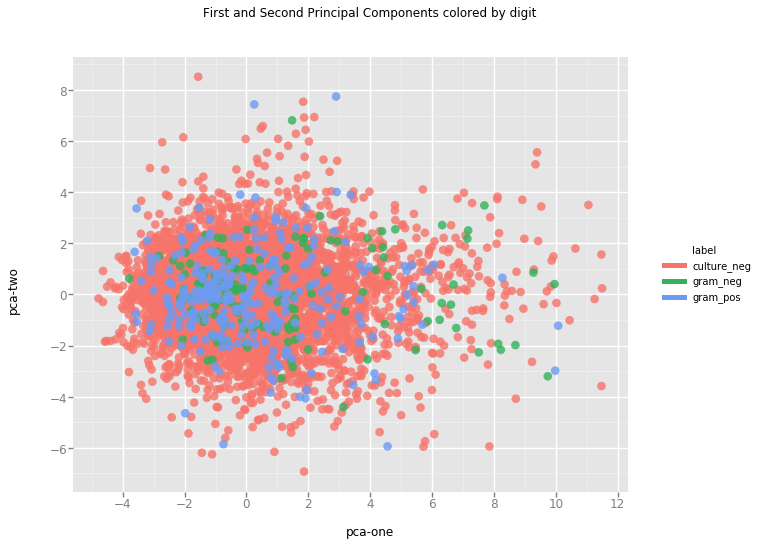

<ggplot: (7572242489)>

time: 585 ms


In [269]:
from ggplot import *
chart = ggplot( x_train_pca.loc[:,:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

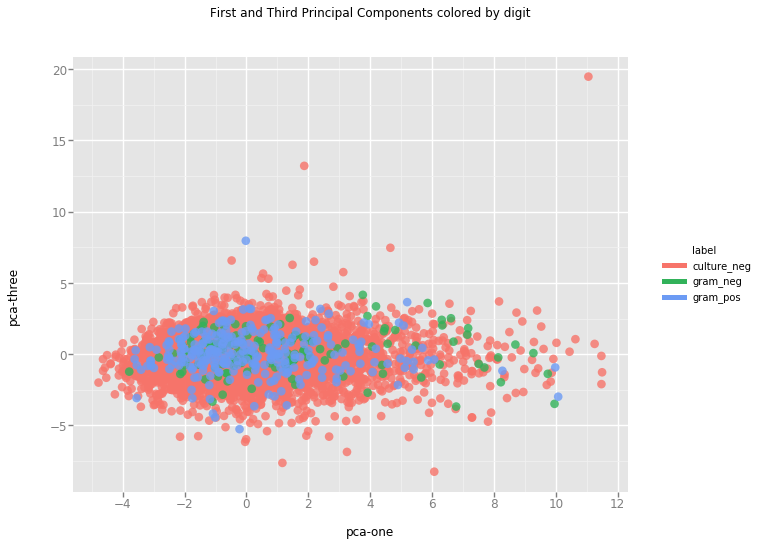

<ggplot: (-9223372029282692152)>

time: 370 ms


In [270]:
chart = ggplot( x_train_pca.loc[:,:], aes(x='pca-one', y='pca-three', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Third Principal Components colored by digit")
chart

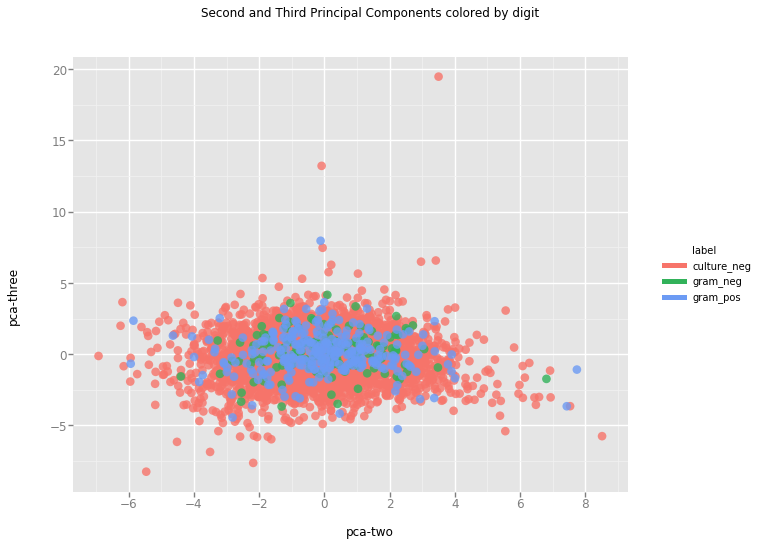

<ggplot: (7563892726)>

time: 1.29 s


In [274]:
chart = ggplot( x_train_pca.loc[:,:], aes(x='pca-two', y='pca-three', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("Second and Third Principal Components colored by digit")
chart

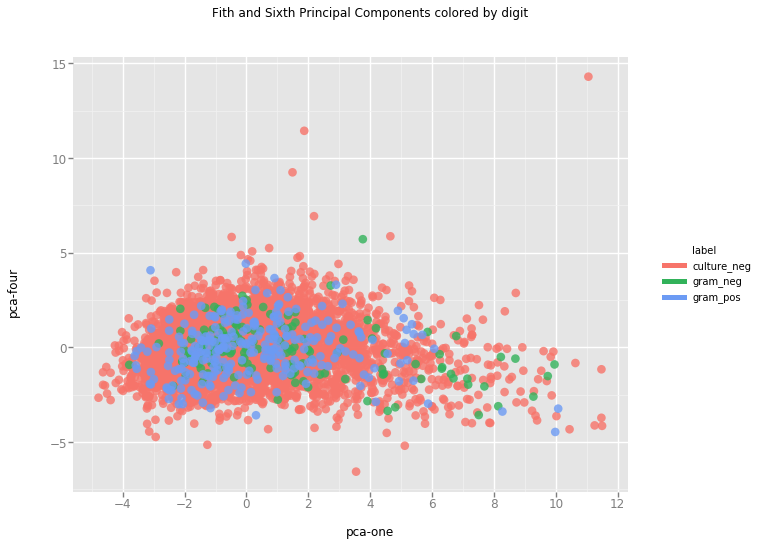

<ggplot: (287659247)>

time: 389 ms


In [271]:
chart = ggplot( x_train_pca.loc[:,:], aes(x='pca-one', y='pca-four', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("Fith and Sixth Principal Components colored by digit")
chart

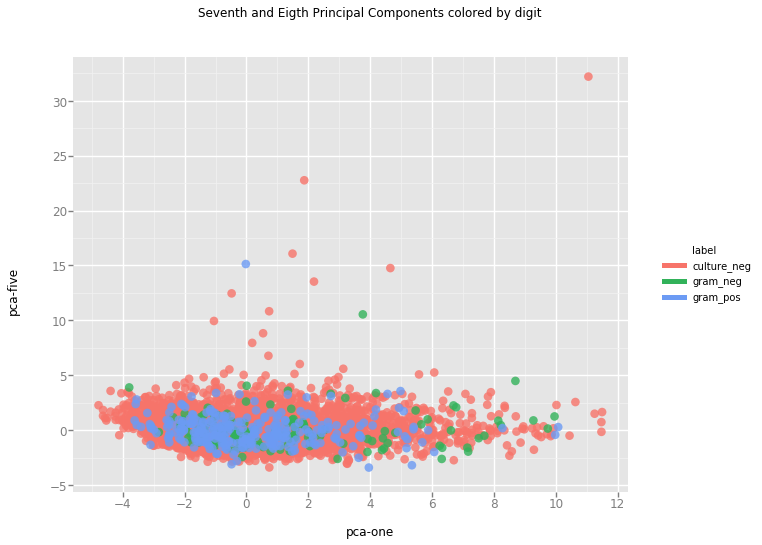

<ggplot: (293010152)>

time: 374 ms


In [272]:
chart = ggplot( x_train_pca.loc[:,:], aes(x='pca-one', y='pca-five', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("Seventh and Eigth Principal Components colored by digit")
chart

In [278]:
import time

from sklearn.manifold import TSNE

x_train_sne= x_train.copy(deep=True) #make a copy of x_train so as to not mess with origional
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_train_sne.values)
print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6039 samples in 0.021s...
[t-SNE] Computed neighbors for 6039 samples in 3.407s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6039
[t-SNE] Computed conditional probabilities for sample 2000 / 6039
[t-SNE] Computed conditional probabilities for sample 3000 / 6039
[t-SNE] Computed conditional probabilities for sample 4000 / 6039
[t-SNE] Computed conditional probabilities for sample 5000 / 6039
[t-SNE] Computed conditional probabilities for sample 6000 / 6039
[t-SNE] Computed conditional probabilities for sample 6039 / 6039
[t-SNE] Mean sigma: 1.454924
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.291718
[t-SNE] KL divergence after 300 iterations: 3.338114
t-SNE done! Time elapsed: 27.074141025543213 seconds
time: 27.1 s


In [279]:
tsne_results

array([[-0.01426161, -1.7995685 ],
       [-6.6630225 , -4.38182   ],
       [-0.09059948,  2.1935475 ],
       ...,
       [ 3.0287395 ,  2.8432195 ],
       [ 3.1569579 ,  2.7153893 ],
       [-4.8244324 ,  1.9627098 ]], dtype=float32)

time: 3.68 ms


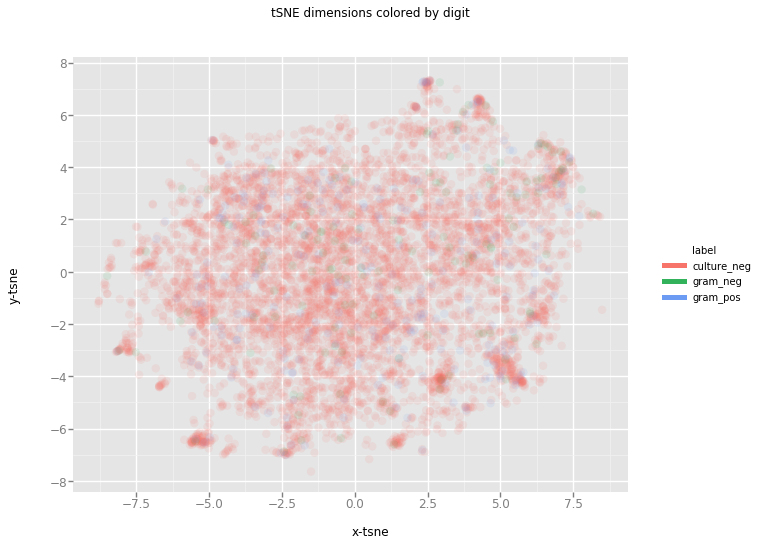

<ggplot: (-9223372029287253830)>

time: 637 ms


In [280]:
x_train_sne['x-tsne'] = tsne_results[:,0]
x_train_sne['y-tsne'] = tsne_results[:,1]
x_train_sne['label']= y_train

chart = ggplot( x_train_sne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

In [235]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x_train.values)
print ('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.9999998397002999
time: 40.6 ms


In [237]:
n_sne = 10000

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50[:])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6039 samples in 0.008s...
[t-SNE] Computed neighbors for 6039 samples in 0.972s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6039
[t-SNE] Computed conditional probabilities for sample 2000 / 6039
[t-SNE] Computed conditional probabilities for sample 3000 / 6039
[t-SNE] Computed conditional probabilities for sample 4000 / 6039
[t-SNE] Computed conditional probabilities for sample 5000 / 6039
[t-SNE] Computed conditional probabilities for sample 6000 / 6039
[t-SNE] Computed conditional probabilities for sample 6039 / 6039
[t-SNE] Mean sigma: 23.092094
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.204918
[t-SNE] KL divergence after 300 iterations: 2.179888
time: 20.5 s


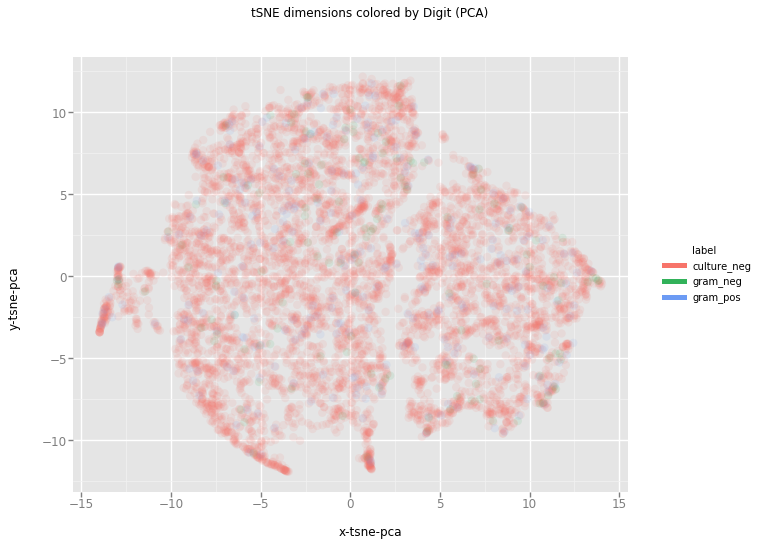

<ggplot: (7562329664)>

time: 384 ms


In [238]:
x_train_sne= None
x_train_sne= x_train.copy(deep=True)
x_train_sne['x-tsne-pca'] = tsne_pca_results[:,0]
x_train_sne['y-tsne-pca'] = tsne_pca_results[:,1]
x_train_sne['label']= y_train

chart = ggplot( x_train_sne, aes(x='x-tsne-pca', y='y-tsne-pca', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by Digit (PCA)")
chart